In [181]:
# Load the necessary libraries
import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# This is for pretty printing
import IPython.display as disp

Constants

In [182]:
# Cell 3: Define physical constants for the system
m1_crank_val, m2_val, m3_val = 1.0, 2.0, 0.5  # Masses (kg) - m1_crank_val is mass of crank arm
L1_val, L2_val = 0.5, 1.5                   # Lengths (m)
I1_crank_val, I2_val = 0.1, 1.5             # Moments of Inertia (kg*m^2) - I1_crank_val is for crank arm about its CoM
F0_val = 50                                 # Force amplitude (N)
k_val = 1                                   # Damping coefficient for crank (Nms/rad)
g_val = 9.81                                # Gravity (m/s^2)

# Flywheel Properties
m_flywheel_val = 50.0 # Mass of the flywheel (kg) - its CoM is at pivot, so its gravity doesn't create torque
r_flywheel_val = 0.25 # Radius of the flywheel (m)
I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2 # Moment of inertia of flywheel about pivot (kg*m^2)

# --- NEW: Gearing Ratio ---
gear_ratio_val = 1.0  # Flywheel rotates 'gear_ratio_val' times for each crank rotation.
                      # e.g., 2.0 means flywheel is faster. 0.5 means flywheel is slower.
# --- END NEW ---

In [183]:
# Cell 4: Define symbolic variables and system matrices
t = sp.symbols('t')
# --- MODIFICATION: Add theta_fw ---
x1, x2, y1, y2, theta1, theta2, x3, y3, theta_fw = dynamicsymbols('x1 x2 y1 y2 theta1 theta2 x3 y3 theta_fw')
q = sp.Matrix([x1, y1, theta1, x2, y2, theta2, x3, y3, theta_fw]) # q now has 9 elements
# --- END MODIFICATION ---
dq = q.diff(t)

x_com_1 = sp.Matrix([x1, y1])
x_com_2 = sp.Matrix([x2, y2])
x_com_3 = sp.Matrix([x3, y3])

R = lambda theta: sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]])

# --- MODIFICATION: Update Mass Matrix for separate flywheel DOF ---
M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,    # Body 1 (crank arm)
                m2_val, m2_val, I2_val,                    # Body 2 (conrod)
                m3_val, m3_val,                            # Body 3 (piston trans DoFs)
                I_flywheel_val])                           # DOF for flywheel rotation (theta_fw)
# --- END MODIFICATION ---

W_np = np.linalg.inv(M_np) # M_np is the correct matrix here

# --- MODIFICATION: Update Q for crank arm gravity and add entry for theta_fw ---
Q = sp.Matrix([0,
               -m1_crank_val * g_val,  # Gravity on crank arm CoM
               -k_val * theta1.diff(t), # Damping/load on crankshaft
               0,
               -m2_val * g_val,         # Gravity on conrod
               0,
               0,
               -m3_val * g_val + F0_val * sp.cos(theta1), # Piston forces
               0])                      # No direct external torque on flywheel DOF
# --- END MODIFICATION ---

In [184]:
# Cell 5: Define constraint equations
i_cap = sp.Matrix([1, 0])
j_cap = sp.Matrix([0, 1])

# Crank pivot at origin
constraint_1 = x_com_1 + R(theta1) @ sp.Matrix([-L1_val/2, 0])
C1 = constraint_1.dot(i_cap)
C2 = constraint_1.dot(j_cap)

# Pin joint: crank - conrod
constraint_2 = (x_com_1 + R(theta1) @ sp.Matrix([L1_val/2, 0])) - \
               (x_com_2 + R(theta2) @ sp.Matrix([-L2_val/2, 0]))
C3 = constraint_2.dot(i_cap)
C4 = constraint_2.dot(j_cap)

# Pin joint: conrod - piston
constraint_3 = (x_com_2 + R(theta2) @ sp.Matrix([L2_val/2, 0])) - x_com_3
C5 = constraint_3.dot(i_cap)
C6 = constraint_3.dot(j_cap)

# Piston slides vertically
constraint_4 = x_com_3[0]
C7 = constraint_4

# --- NEW: Gearing Constraint ---
# theta_fw = gear_ratio * theta1 (assuming they start aligned, or phase offset is 0)
# So, theta_fw - gear_ratio_val * theta1 = 0
C_gear = theta_fw - gear_ratio_val * theta1
C8 = C_gear
# --- END NEW ---

# --- MODIFICATION: Add C8 to constraint matrix C ---
C = sp.Matrix([C1, C2, C3, C4, C5, C6, C7, C8]) # C now has 8 constraint equations
# --- END MODIFICATION ---

In [185]:
# Cell 6: Formulate terms for DAE solution and lambdify
J = C.jacobian(q) # J is now 8x9

dC_expr = J @ dq
dJ_times_dq_dt_expr = dC_expr.jacobian(q) @ dq

# --- MODIFICATION: Adjust shape of W_sym ---
W_sym = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1]) # Shape is now 9x9
# --- END MODIFICATION ---

RHS_sym = -dJ_times_dq_dt_expr - J @ W_sym @ Q - 10 * C - 10 * dC_expr # Baumgarte params can be tuned

JWJT_fn = sp.lambdify(args=(q, dq, W_sym), expr=(J @ W_sym @ J.T), modules=['numpy', 'sympy'])
RHS_fn = sp.lambdify(args=(q, dq, W_sym), expr=RHS_sym, modules=['numpy', 'sympy'])

C_fn_num = sp.lambdify(args=(q,), expr=C, modules=['numpy', 'sympy'])
J_fn_num = sp.lambdify(args=(q,), expr=J, modules=['numpy', 'sympy'])
Q_fn_num = sp.lambdify(args=(q, dq), expr=Q, modules=['numpy', 'sympy'])
dC_fn_num = sp.lambdify(args=(q, dq), expr=dC_expr, modules=['numpy', 'sympy'])

In [186]:
# Cell 7: Set up and refine initial conditions
dtheta1_init = 0.5 # rad/s

# --- MODIFICATION: Add initial theta_fw ---
# Assuming theta_fw starts aligned with theta1 according to gear ratio
theta1_init_val = np.pi/2
theta_fw_init_val = gear_ratio_val * theta1_init_val

q_init_guess = np.array([
    0, L1_val/2, theta1_init_val,               # x1, y1, theta1
    0, L1_val + L2_val/2, np.pi/2,              # x2, y2, theta2
    0, L1_val + L2_val,                         # x3, y3
    theta_fw_init_val                           # theta_fw
])
# --- END MODIFICATION ---

C_at_init_pos = C_fn_num(q_init_guess).flatten()
print(f"Initial position constraint violation C(q_init_guess): \n{C_at_init_pos}")
assert np.allclose(C_at_init_pos, 0, atol=1e-6), "Chosen initial positions DO NOT satisfy constraints C=0!"

# --- MODIFICATION: Update velocity_constraint_solver ---
# dq = [dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3, dtheta_fw]
# known_dtheta1 is dq[2].
# From dC8/dt = 0: dtheta_fw_dt - gear_ratio * dtheta1_dt = 0
# So, dtheta_fw_dt = gear_ratio * dtheta1_dt. This is dq[8].
# The solver finds the other 7: b_vel = [dx1, dy1, dx2, dy2, dtheta2, dx3, dy3]

def velocity_constraint_solver(b_vel, q_pos, known_dtheta1, known_dtheta_fw):
    # b_vel has 7 elements
    dq_full = np.array([
        b_vel[0], b_vel[1], known_dtheta1,    # dx1, dy1, dtheta1
        b_vel[2], b_vel[3], b_vel[4],    # dx2, dy2, dtheta2
        b_vel[5], b_vel[6],              # dx3, dy3
        known_dtheta_fw                  # dtheta_fw
    ])
    J_num = J_fn_num(q_pos) # J_num is 8x9
    dC_val_all = (J_num @ dq_full).flatten() # Should be 8 zeros
    # We are explicitly setting dtheta_fw_dt based on dtheta1_dt, so dC8/dt should be zero.
    # The solver needs to make the first 7 components of dC_val_all zero.
    return dC_val_all[:7] # Return only the first 7 constraint velocity equations for the 7 unknowns

import scipy.optimize as opt
b_vel_guess = np.zeros(7) # 7 unknowns now

# Enforce the gear ratio for initial velocities
dtheta_fw_init = gear_ratio_val * dtheta1_init

solution = opt.root(velocity_constraint_solver, b_vel_guess,
                    args=(q_init_guess, dtheta1_init, dtheta_fw_init),
                    method='hybr', options={'xtol': 1e-8}) # Added xtol for robustness

if not solution.success:
    print(f"Warning: Initial velocity optimization might not have converged. Message: {solution.message}")

b_vel_sol = solution.x
dq_init_consistent = np.array([
    b_vel_sol[0], b_vel_sol[1], dtheta1_init,
    b_vel_sol[2], b_vel_sol[3], b_vel_sol[4],
    b_vel_sol[5], b_vel_sol[6],
    dtheta_fw_init # dq[8] is dtheta_fw
])
# --- END MODIFICATION ---

# Verify all constraints
J_num_init = J_fn_num(q_init_guess)
dC_at_init_vel_all = (J_num_init @ dq_init_consistent).flatten()
print(f"Full initial velocity constraint violation dC(q_init, dq_consistent): \n{dC_at_init_vel_all}")
assert np.allclose(dC_at_init_vel_all, 0, atol=1e-6), "Solved initial velocities DO NOT satisfy all dC=0!"

x0 = np.concatenate((q_init_guess, dq_init_consistent))
print("\nConsistent initial state vector x0 (9 positions, 9 velocities):")
print(x0)

Initial position constraint violation C(q_init_guess): 
[-1.5308085e-17  0.0000000e+00  6.1232340e-17  0.0000000e+00
  4.5924255e-17  0.0000000e+00  0.0000000e+00  0.0000000e+00]
Full initial velocity constraint violation dC(q_init, dq_consistent): 
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.43492963e-42 -1.89911355e-65  0.00000000e+00]

Consistent initial state vector x0 (9 positions, 9 velocities):
[ 0.00000000e+00  2.50000000e-01  1.57079633e+00  0.00000000e+00
  1.25000000e+00  1.57079633e+00  0.00000000e+00  2.00000000e+00
  1.57079633e+00 -1.25000000e-01  7.65404249e-18  5.00000000e-01
 -1.25000000e-01  7.65404249e-18 -1.66666667e-01 -1.89911355e-65
  1.43492963e-42  5.00000000e-01]


Calculate initial conditions for the system

In [187]:
# import scipy.optimize as opt

# x, _ = np.split(x0, 2)
# def optimiser(b):
#     dx1, dy1, dx2, dy2, dtheta2, dx3, dy3 = b
#     dq = np.array([dx1, dy1, dtheta1, dx2, dy2, dtheta2, dx3, dy3])
#     val = dC_fn(x, dq).flatten()
#     return val

# initial_guess = np.array([0, 0, 0, 0, 0, 0, 0])
# result = opt.root(optimiser, initial_guess)
# print(result)

# b = result.x
# dx = np.array([b[0], b[1], dtheta1, b[2], b[3], b[4], b[5], b[6]])

# C_val = C_fn(x, dx)
# dC_val = dC_fn(x, dx)

# print(f'Position constraint: {C_val}')
# print(f'Velocity constraint: {dC_val}')
# assert np.allclose(C_val, 0), "Initial position constraint violated"
# assert np.allclose(dC_val, 0), "Initial velocity constraint violated"
# x0 = np.concatenate((x, dx))
# x0

In [188]:
# Cell 8: Define the function for the DAE solver (name is already appropriate)
def piston_engine_flywheel(t, state):
    q_num, dq_num = np.split(state, 2)

    JWJT_val = JWJT_fn(q_num, dq_num, W_np)
    RHS_val = RHS_fn(q_num, dq_num, W_np)

    try:
        lam = np.linalg.solve(JWJT_val, RHS_val)
    except np.linalg.LinAlgError:
        print(f"Singular matrix encountered at t={t}. Using pseudo-inverse.")
        lam = np.linalg.pinv(JWJT_val) @ RHS_val

    J_val_num = J_fn_num(q_num)
    Qhat = J_val_num.T @ lam

    Q_val_num = Q_fn_num(q_num, dq_num)
    ddq = W_np @ (Q_val_num + Qhat)
    ddq = ddq.flatten()

    return np.concatenate((dq_num, ddq))

# Test run
initial_derivatives = piston_engine_flywheel(0, x0)
print("\nInitial derivatives (dq, ddq) from test run:")
print(initial_derivatives)


Initial derivatives (dq, ddq) from test run:
[-1.25000000e-01  7.65404249e-18  5.00000000e-01 -1.25000000e-01
  7.65404249e-18 -1.66666667e-01 -1.89911355e-65  1.43492963e-42
  5.00000000e-01  6.19834711e-02 -6.25000000e-02 -2.47933884e-01
  6.19834711e-02 -1.45833333e-01  8.26446281e-02  0.00000000e+00
 -1.66666667e-01 -2.47933884e-01]


In [189]:
# Cell 9: Run the numerical simulation
t_start = 0
t_end = 10 # Reduced time for quicker test, original was 30
num_points = 500 # Original was 500

t_span = (t_start, t_end)
t_eval = np.linspace(*t_span, num_points)

print("\nStarting numerical integration...")
sol = solve_ivp(piston_engine_flywheel, t_span, x0,
                atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval)
print("Integration finished.")
print(f"Solver status: {sol.message}")
if not sol.success:
    print("Warning: Solver did not terminate successfully.")

# Explanation:
# t_start, t_end, num_points: Parameters for the simulation time.
# t_span: Tuple defining the start and end time of the simulation.
# t_eval: Array of time points where the solution should be stored.
# solve_ivp: Solves the system of DAEs.
#    - piston_engine_flywheel: The function defining the system dynamics.
#    - t_span: Integration interval.
#    - x0: Consistent initial state.
#    - atol, rtol: Absolute and relative error tolerances for the solver.
#    - method='BDF': Uses the Backward Differentiation Formula, good for stiff DAEs.
#    - t_eval: Times at which to store the solution.
# sol: The solution object containing time points (sol.t) and state vectors (sol.y).
# Print statements provide feedback on the integration process.


Starting numerical integration...


Integration finished.
Solver status: The solver successfully reached the end of the integration interval.


Animation

In [190]:
# Class for drawing the box
class Box:
    def __init__(self, width, height, color='b'):
        self.width = width
        self.height = height
        self.color = color
        self.offset = -np.array([width/2, height/2])

    def first_draw(self, ax):
        corner = np.array([0, 0])
        self.patch = plt.Rectangle(corner, 0, 0, angle=0, 
                        rotation_point='center', color=self.color, animated=True)
        ax.add_patch(self.patch)
        self.ax = ax
        return self.patch
    
    def set_data(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta

    def update(self, i):
        x, y, theta = self.x[i], self.y[i], self.theta[i]
        theta = np.rad2deg(theta)

        # The rectangle is drawn from the left bottom corner
        # So, we need to calculate the corner position
        corner = np.array([x, y]) + self.offset

        # Update the values for the rectangle
        self.patch.set_width(self.width)
        self.patch.set_height(self.height)
        self.patch.set_xy(corner)
        self.patch.set_angle(theta)
        return self.patch
    
# --- MODIFICATION: Corrected Circle class for the flywheel WITH a rotating line ---
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

class FlywheelVisual:
    def __init__(self, radius, color='dimgray', line_color='black', line_angle_offset_rad=np.pi/2):
        self.radius = radius
        self.color = color
        self.line_color = line_color
        self.line_angle_offset_rad = line_angle_offset_rad
        self.patch = None
        self.line = None

    def first_draw(self, ax):
        self.patch = Circle((0,0), self.radius, fc=self.color, animated=True, zorder=1)
        ax.add_patch(self.patch)
        self.line = Line2D([0, 0], [0, 0], color=self.line_color, lw=2, animated=True, zorder=2)
        ax.add_line(self.line)
        return [self.patch, self.line]

    # --- MODIFICATION: set_data now takes theta_flywheel_array ---
    def set_data(self, center_x_array, center_y_array, theta_flywheel_array):
        self.center_x_array = center_x_array
        self.center_y_array = center_y_array
        self.theta_flywheel_array = theta_flywheel_array # This is the flywheel's own angle
    # --- END MODIFICATION ---

    def update(self, i):
        cx = self.center_x_array[i]
        cy = self.center_y_array[i]
        self.patch.center = (cx, cy)
        
        # --- MODIFICATION: Line rotates with theta_flywheel, offset is for visual distinction ---
        th_flywheel_effective = self.theta_flywheel_array[i] + self.line_angle_offset_rad
        # --- END MODIFICATION ---
        
        line_start_x = cx
        line_start_y = cy
        line_end_x = cx + self.radius * np.cos(th_flywheel_effective)
        line_end_y = cy + self.radius * np.sin(th_flywheel_effective)
        
        self.line.set_data([line_start_x, line_end_x], [line_start_y, line_end_y])
        
        return [self.patch, self.line]

In [191]:
# Cell 12: Create and display the animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig_anim, ax_anim = plt.subplots(figsize=(6,8))
plt.close(fig_anim)

ax_anim.set_ylim(- (L1_val + L2_val + r_flywheel_val + 0.2), (L1_val + L2_val + r_flywheel_val + 0.2) )
ax_anim.set_xlim(- (L1_val + r_flywheel_val + 0.2), (L1_val + r_flywheel_val + 0.2) )
ax_anim.set_aspect('equal')
ax_anim.grid(True)

# Get the position and angle data from the solution
# sol.y now contains [x1,y1,th1, x2,y2,th2, x3,y3, th_fw]
x1_sol, y1_sol, theta1_sol = sol.y[0,:], sol.y[1,:], sol.y[2,:]
x2_sol, y2_sol, theta2_sol = sol.y[3,:], sol.y[4,:], sol.y[5,:]
x3_sol, y3_sol             = sol.y[6,:], sol.y[7,:]
theta_fw_sol               = sol.y[8,:] # --- NEW: Extract flywheel angle ---
theta3_sol = np.zeros_like(x3_sol)

crank_visual = Box(L1_val, 0.05, color='blue')
conrod_visual = Box(L2_val, 0.05, color='red')
piston_visual = Box(0.2, 0.4, color='green')

# --- MODIFICATION: Flywheel line angle offset (e.g., 0 or np.pi/2 for visibility if gear_ratio=1) ---
# If gear_ratio is not 1, offset might not be needed as it will naturally differ from crank.
# Let's set offset to 0 for now, so line directly indicates theta_fw.
flywheel_visual_obj = FlywheelVisual(r_flywheel_val, color='dimgray', line_color='black', line_angle_offset_rad=0)
# --- END MODIFICATION ---

crank_visual.set_data(x1_sol, y1_sol, theta1_sol)
conrod_visual.set_data(x2_sol, y2_sol, theta2_sol)
piston_visual.set_data(x3_sol, y3_sol, theta3_sol)

flywheel_center_x_data = np.zeros_like(theta1_sol)
flywheel_center_y_data = np.zeros_like(theta1_sol)
# --- MODIFICATION: Pass theta_fw_sol to flywheel visual ---
flywheel_visual_obj.set_data(flywheel_center_x_data, flywheel_center_y_data, theta_fw_sol)
# --- END MODIFICATION ---

artists_to_animate = [flywheel_visual_obj, piston_visual, conrod_visual, crank_visual]

# init_animation and animate_frame functions remain the same as the previous corrected version.
def init_animation():
    ax_anim.set_title("t=0.00 sec", fontsize=15)
    all_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.first_draw(ax_anim)
        if isinstance(patches_from_obj, list):
            all_patches_flat.extend(patches_from_obj)
        else:
            all_patches_flat.append(patches_from_obj)
    return all_patches_flat

def animate_frame(i):
    ax_anim.set_title(f"t={sol.t[i]:.2f} sec", fontsize=15)
    updated_patches_flat = []
    for artist_obj in artists_to_animate:
        patches_from_obj = artist_obj.update(i)
        if isinstance(patches_from_obj, list):
            updated_patches_flat.extend(patches_from_obj)
        else:
            updated_patches_flat.append(patches_from_obj)
    return updated_patches_flat

sim_dt = sol.t[1] - sol.t[0] if len(sol.t) > 1 else 0.04
animation_interval_ms = 1000 * sim_dt

anim_piston = FuncAnimation(fig_anim, animate_frame, frames=len(sol.t),
                            init_func=init_animation, blit=False, interval=max(20, animation_interval_ms))

html_video = HTML(anim_piston.to_html5_video())
disp.display(html_video)

In [192]:
# Cell 13: Helper functions for parameter variation and simulation setup
# Store original constants from Cell 3 (and any other relevant ones)
original_constants = {
    "m1_crank_val": m1_crank_val, "m2_val": m2_val, "m3_val": m3_val,
    "L1_val": L1_val, "L2_val": L2_val,
    "I1_crank_val": I1_crank_val, "I2_val": I2_val,
    "F0_val": F0_val, "k_val": k_val, "g_val": g_val,
    "m_flywheel_val": m_flywheel_val, "r_flywheel_val": r_flywheel_val,
    "gear_ratio_val": gear_ratio_val # Crucial for symbolic changes
}

current_constants_store = {} # To backup global variables during looped simulations

def update_and_set_globals(param_name_to_change, param_value):
    """
    Updates global Python variables based on the parameter being varied.
    It uses 'original_constants' as a base and modifies the specific parameter.
    It also recalculates derived constants like I_flywheel_val, M_np, W_np.
    Returns the 'current' gear_ratio_val, which is needed by setup_symbolic_system and get_initial_conditions_param.
    """
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    global gear_ratio_val # This is a Python global that Sympy expressions might use
    global M_np, W_np, q_sym_size # These are numpy arrays/globals used by solver

    # Store original global values if not already done for this "session" of running the loop
    if not current_constants_store:
        current_constants_store["m1_crank_val"] = original_constants["m1_crank_val"]
        current_constants_store["m2_val"] = original_constants["m2_val"]
        current_constants_store["m3_val"] = original_constants["m3_val"]
        current_constants_store["L1_val"] = original_constants["L1_val"]
        current_constants_store["L2_val"] = original_constants["L2_val"]
        current_constants_store["I1_crank_val"] = original_constants["I1_crank_val"]
        current_constants_store["I2_val"] = original_constants["I2_val"]
        current_constants_store["F0_val"] = original_constants["F0_val"]
        current_constants_store["k_val"] = original_constants["k_val"]
        current_constants_store["g_val"] = original_constants["g_val"]
        current_constants_store["m_flywheel_val"] = original_constants["m_flywheel_val"]
        current_constants_store["r_flywheel_val"] = original_constants["r_flywheel_val"]
        current_constants_store["gear_ratio_val"] = original_constants["gear_ratio_val"]

    # Create a working copy from original_constants, then update the specific param
    temp_constants = original_constants.copy()
    temp_constants[param_name_to_change] = param_value
    
    # Update global Python variables from temp_constants
    # These globals will be used by setup_symbolic_system when defining SymPy expressions
    m1_crank_val = temp_constants["m1_crank_val"]
    m2_val = temp_constants["m2_val"]
    m3_val = temp_constants["m3_val"]
    L1_val = temp_constants["L1_val"]
    L2_val = temp_constants["L2_val"]
    I1_crank_val = temp_constants["I1_crank_val"]
    I2_val = temp_constants["I2_val"]
    F0_val = temp_constants["F0_val"]
    k_val = temp_constants["k_val"]
    g_val = temp_constants["g_val"]
    m_flywheel_val = temp_constants["m_flywheel_val"]
    r_flywheel_val = temp_constants["r_flywheel_val"]
    gear_ratio_val = temp_constants["gear_ratio_val"]

    # Update derived constants that affect M_np, W_np
    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val,
                    m2_val, m2_val, I2_val,
                    m3_val, m3_val,
                    I_flywheel_val])
    if M_np.shape[0] == 0: # Should not happen if constants are numbers
        raise ValueError("M_np is empty. Check constant definitions.")
    W_np = np.linalg.inv(M_np)
    q_sym_size = M_np.shape[0] # Number of generalized coordinates
    
    return temp_constants["gear_ratio_val"] # Return the gear_ratio_val used for this run

def restore_globals_from_original():
    """Restores global Python variables from the 'original_constants' dictionary."""
    global m1_crank_val, m2_val, m3_val, L1_val, L2_val, I1_crank_val, I2_val
    global F0_val, k_val, g_val, m_flywheel_val, r_flywheel_val, I_flywheel_val
    global gear_ratio_val, M_np, W_np
    
    m1_crank_val = original_constants["m1_crank_val"]
    m2_val = original_constants["m2_val"]
    m3_val = original_constants["m3_val"]
    L1_val = original_constants["L1_val"]
    L2_val = original_constants["L2_val"]
    I1_crank_val = original_constants["I1_crank_val"]
    I2_val = original_constants["I2_val"]
    F0_val = original_constants["F0_val"]
    k_val = original_constants["k_val"]
    g_val = original_constants["g_val"]
    m_flywheel_val = original_constants["m_flywheel_val"]
    r_flywheel_val = original_constants["r_flywheel_val"]
    gear_ratio_val = original_constants["gear_ratio_val"]
        
    I_flywheel_val = 0.5 * m_flywheel_val * r_flywheel_val**2
    M_np = np.diag([m1_crank_val, m1_crank_val, I1_crank_val, m2_val, m2_val, I2_val, m3_val, m3_val, I_flywheel_val])
    W_np = np.linalg.inv(M_np)
    
    current_constants_store.clear() # Clear the backup store

# Global placeholder for current lambdified functions, to be used by the solver
current_lambdified_fns = {}

def setup_symbolic_system_param(current_gear_ratio_val_sym):
    """
    Re-defines symbolic expressions and re-lambdifies them.
    Uses current global Python variables for physical constants (e.g., L1_val, m1_crank_val).
    'current_gear_ratio_val_sym' is the specific value for gear_ratio for this setup.
    """
    # Make sure SymPy dynamicsymbols are available (usually from Cell 1)
    # from sympy.physics.mechanics import dynamicsymbols 
    
    t_loc = sp.symbols('t')
    # Using _loc to avoid collision if these are already global SymPy symbols
    x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc = dynamicsymbols('x1 y1 theta1 x2 y2 theta2 x3 y3 theta_fw')
    q_loc = sp.Matrix([x1_loc, y1_loc, theta1_loc, x2_loc, y2_loc, theta2_loc, x3_loc, y3_loc, theta_fw_loc])
    dq_loc = q_loc.diff(t_loc)

    # Q matrix (Cell 4, uses current global Python variables for constants)
    Q_expr_loc = sp.Matrix([0,
                       -m1_crank_val * g_val,
                       -k_val * theta1_loc.diff(t_loc),
                       0,
                       -m2_val * g_val,
                       0,
                       0,
                       -m3_val * g_val + F0_val * sp.cos(theta1_loc),
                       0])

    # Constraints (Cell 5, uses current global Python variables for L1_val, L2_val etc.)
    x_com_1_loc = sp.Matrix([x1_loc, y1_loc])
    x_com_2_loc = sp.Matrix([x2_loc, y2_loc])
    x_com_3_loc = sp.Matrix([x3_loc, y3_loc])
    _R_loc = lambda theta_arg: sp.Matrix([[sp.cos(theta_arg), -sp.sin(theta_arg)], [sp.sin(theta_arg), sp.cos(theta_arg)]])
    i_cap_loc = sp.Matrix([1, 0])
    j_cap_loc = sp.Matrix([0, 1])

    constraint_1_loc = x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([-L1_val/2, 0])
    C1_loc = constraint_1_loc.dot(i_cap_loc)
    C2_loc = constraint_1_loc.dot(j_cap_loc)
    constraint_2_loc = (x_com_1_loc + _R_loc(theta1_loc) @ sp.Matrix([L1_val/2, 0])) - \
                       (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([-L2_val/2, 0]))
    C3_loc = constraint_2_loc.dot(i_cap_loc)
    C4_loc = constraint_2_loc.dot(j_cap_loc)
    constraint_3_loc = (x_com_2_loc + _R_loc(theta2_loc) @ sp.Matrix([L2_val/2, 0])) - x_com_3_loc
    C5_loc = constraint_3_loc.dot(i_cap_loc)
    C6_loc = constraint_3_loc.dot(j_cap_loc)
    constraint_4_loc = x_com_3_loc[0]
    C7_loc = constraint_4_loc
    # Use the passed current_gear_ratio_val_sym for this specific setup
    C_gear_loc = theta_fw_loc - current_gear_ratio_val_sym * theta1_loc 
    C8_loc = C_gear_loc
    C_expr_loc = sp.Matrix([C1_loc, C2_loc, C3_loc, C4_loc, C5_loc, C6_loc, C7_loc, C8_loc])

    # DAE terms (Cell 6)
    J_expr_loc = C_expr_loc.jacobian(q_loc)
    dC_expr_loc_dt = J_expr_loc @ dq_loc # This is dC/dt, not dC_expr
    # dJ_times_dq_dt_expr_loc = dC_expr_loc_dt.jacobian(q_loc) @ dq_loc # This is (d/dq (J dq)) dq
    # A more standard way for dJ/dt * dq :
    dJdt_expr_loc = J_expr_loc.diff(t_loc) # This works if symbols in J are dynamic symbols
    dJ_times_dq_dt_expr_loc = dJdt_expr_loc @ dq_loc


    # W_sym uses the global M_np's shape, which should be up-to-date via update_and_set_globals
    W_sym_loc = sp.MatrixSymbol('W_matrix', M_np.shape[0], M_np.shape[1])
    # Baumgarte stabilization terms alpha=10, beta=10 (can be tuned)
    alpha_baum = 10 
    beta_baum = 10
    RHS_sym_expr_loc = -dJ_times_dq_dt_expr_loc - J_expr_loc @ W_sym_loc @ Q_expr_loc - beta_baum * dC_expr_loc_dt - alpha_baum * C_expr_loc


    lambdified_fns_dict = {
        "JWJT_fn": sp.lambdify(args=(q_loc, dq_loc, W_sym_loc), expr=(J_expr_loc @ W_sym_loc @ J_expr_loc.T), modules=['numpy', 'sympy']),
        "RHS_fn": sp.lambdify(args=(t_loc, q_loc, dq_loc, W_sym_loc), expr=RHS_sym_expr_loc, modules=['numpy', 'sympy']), # Added t_loc
        "C_fn_num": sp.lambdify(args=(q_loc,), expr=C_expr_loc, modules=['numpy', 'sympy']),
        "J_fn_num": sp.lambdify(args=(q_loc,), expr=J_expr_loc, modules=['numpy', 'sympy']),
        "Q_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=Q_expr_loc, modules=['numpy', 'sympy']), # Added t_loc
        "dC_dt_fn_num": sp.lambdify(args=(t_loc, q_loc, dq_loc), expr=dC_expr_loc_dt, modules=['numpy', 'sympy']), # Added t_loc
        "num_gen_coords": q_loc.shape[0] # Store the number of generalized coordinates
    }
    return lambdified_fns_dict

def get_initial_conditions_param(fns_dict, current_gear_ratio_val_ic):
    """
    Calculates consistent initial conditions using the provided lambdified functions
    and the specific gear_ratio_val for this run.
    """
    _J_fn_num_ic = fns_dict["J_fn_num"]
    _C_fn_num_ic = fns_dict["C_fn_num"]
    
    dtheta1_init_ic = 0.5 
    theta1_init_val_ic = np.pi/2 
    # Use the gear_ratio_val specific to this run for initial conditions
    theta_fw_init_val_ic = current_gear_ratio_val_ic * theta1_init_val_ic

    # L1_val, L2_val are current global Python variables
    q_init_guess_ic = np.array([
        0, L1_val/2, theta1_init_val_ic,
        0, L1_val + L2_val/2, np.pi/2,
        0, L1_val + L2_val,
        theta_fw_init_val_ic
    ])

    # Refine initial positions to satisfy C(q)=0 using Newton-Raphson
    for _ in range(10): # Max 10 iterations for position refinement
        C_at_init_pos_val = _C_fn_num_ic(q_init_guess_ic).flatten()
        if np.allclose(C_at_init_pos_val, 0, atol=1e-7):
            break
        J_at_init_pos_val = _J_fn_num_ic(q_init_guess_ic)
        try:
            # Use pseudo-inverse for potentially non-square or singular J during refinement
            delta_q = np.linalg.lstsq(J_at_init_pos_val, -C_at_init_pos_val, rcond=None)[0]
        except np.linalg.LinAlgError:
            print("LinAlgError during position refinement, trying pseudo-inverse more directly.")
            delta_q = np.linalg.pinv(J_at_init_pos_val) @ -C_at_init_pos_val

        q_init_guess_ic = q_init_guess_ic + delta_q.flatten()
    else: # If loop finished without break
        C_final_check = _C_fn_num_ic(q_init_guess_ic).flatten()
        if not np.allclose(C_final_check, 0, atol=1e-5): # Relax tolerance slightly after iterations
             print(f"Warning: Initial position refinement might not have fully converged. Violation: {C_final_check}")
        # assert np.allclose(C_final_check, 0, atol=1e-5), f"Initial positions DO NOT satisfy C=0 after refinement! Violation: {C_final_check}"


    def velocity_constraint_solver_ic(b_vel, q_pos, known_dtheta1, known_dtheta_fw):
        dq_full = np.array([
            b_vel[0], b_vel[1], known_dtheta1,
            b_vel[2], b_vel[3], b_vel[4],
            b_vel[5], b_vel[6],
            known_dtheta_fw
        ])
        J_num_val = _J_fn_num_ic(q_pos)
        dC_val_all = (J_num_val @ dq_full).flatten()
        return dC_val_all[:7] # Solve for the first 7 dC/dt = 0

    b_vel_guess_ic = np.zeros(7)
    dtheta_fw_init_ic = current_gear_ratio_val_ic * dtheta1_init_ic
    
    # scipy.optimize needs to be imported, assume it's available from original notebook (Cell 7)
    # import scipy.optimize as opt 
    solution_ic = opt.root(velocity_constraint_solver_ic, b_vel_guess_ic,
                        args=(q_init_guess_ic, dtheta1_init_ic, dtheta_fw_init_ic),
                        method='hybr', options={'xtol': 1e-9, 'maxfev': 2000*(7+1)})


    if not solution_ic.success:
        print(f"Warning: Initial velocity optimization might not have converged for gear_ratio={current_gear_ratio_val_ic}. Msg: {solution_ic.message}")

    b_vel_sol_ic = solution_ic.x
    dq_init_consistent_ic = np.array([
        b_vel_sol_ic[0], b_vel_sol_ic[1], dtheta1_init_ic,
        b_vel_sol_ic[2], b_vel_sol_ic[3], b_vel_sol_ic[4],
        b_vel_sol_ic[5], b_vel_sol_ic[6],
        dtheta_fw_init_ic
    ])

    J_num_init_val = _J_fn_num_ic(q_init_guess_ic)
    dC_at_init_vel_all_val = (J_num_init_val @ dq_init_consistent_ic).flatten()
    if not np.allclose(dC_at_init_vel_all_val, 0, atol=1e-5):
        print(f"Warning: Solved IC velocities DO NOT satisfy dC=0! Violation for gr={current_gear_ratio_val_ic}: {dC_at_init_vel_all_val}")
    # assert np.allclose(dC_at_init_vel_all_val, 0, atol=1e-5), f"Solved IC velocities DO NOT satisfy dC=0! Violation for gr={current_gear_ratio_val_ic}: {dC_at_init_vel_all_val}"
    
    return np.concatenate((q_init_guess_ic, dq_init_consistent_ic))

def piston_engine_flywheel_param_solver(t_param, state_param):
    """
    Solver function for solve_ivp, uses current_lambdified_fns and global W_np.
    """
    _JWJT_fn_param = current_lambdified_fns["JWJT_fn"]
    _RHS_fn_param = current_lambdified_fns["RHS_fn"]
    _J_fn_num_param = current_lambdified_fns["J_fn_num"]
    _Q_fn_num_param = current_lambdified_fns["Q_fn_num"]
    
    num_coords = current_lambdified_fns["num_gen_coords"]
    q_num_param, dq_num_param = np.split(state_param, 2)

    # W_np is global and updated by update_and_set_globals
    JWJT_val_param = _JWJT_fn_param(q_num_param, dq_num_param, W_np) 
    RHS_val_param = _RHS_fn_param(t_param, q_num_param, dq_num_param, W_np).flatten() # Ensure RHS is 1D

    try:
        lam_param = np.linalg.solve(JWJT_val_param, RHS_val_param)
    except np.linalg.LinAlgError:
        # print(f"Singular matrix at t={t_param:.3f}. Using pseudo-inverse.")
        lam_param = np.linalg.pinv(JWJT_val_param) @ RHS_val_param

    J_val_num_param = _J_fn_num_param(q_num_param)
    Qhat_param = J_val_num_param.T @ lam_param.reshape(-1,1) # Ensure lam_param is column vector
    
    Q_val_num_param = _Q_fn_num_param(t_param, q_num_param, dq_num_param)
    ddq_param = W_np @ (Q_val_num_param + Qhat_param) # Qhat_param is (9,1), Q_val_num_param is (9,1)
    ddq_param = ddq_param.flatten()

    return np.concatenate((dq_num_param, ddq_param))

In [193]:
# Cell 14: Main simulation loop for parameter variation

# --- CHOOSE PARAMETER TO VARY ---
# parameter_to_vary = "gear_ratio_val"
# values_to_test = [0.5, 1.0, 2.0]

# parameter_to_vary = "m_flywheel_val"
# values_to_test = [25.0, 50.0, 75.0]

parameter_to_vary = "r_flywheel_val"
values_to_test = [0.15, 0.25, 0.35]

# ----------------------------------

all_simulation_results = []

# Ensure original globals are stored once before starting the loop
if not current_constants_store:
    # This call initializes current_constants_store with values of globals *as they are now*
    # It's important that these globals are at their 'original' state as defined in notebook Cell 3
    # before this loop is first run.
    update_and_set_globals("gear_ratio_val", original_constants["gear_ratio_val"]) # Dummy call to populate store
    restore_globals_from_original() # Ensure it's truly reset to Cell 3 values.

print(f"Starting simulations, varying: {parameter_to_vary}")
for val_idx, current_val_to_test in enumerate(values_to_test):
    print(f"  Run {val_idx+1}/{len(values_to_test)}: {parameter_to_vary} = {current_val_to_test}")
    
    # Update global Python variables (L1_val, m1_crank_val, etc.) and derived M_np, W_np
    # The returned effective_gear_ratio is the one set by this update, which might be param_value itself or original_constants["gear_ratio_val"]
    effective_gear_ratio_for_run = update_and_set_globals(parameter_to_vary, current_val_to_test)
    
    # Setup symbolic system using current global Python variables and the effective_gear_ratio
    # This updates the global 'current_lambdified_fns'
    current_lambdified_fns = setup_symbolic_system_param(effective_gear_ratio_for_run)
    
    # Get initial conditions using the newly setup lambdified functions and the effective_gear_ratio
    x0_run = get_initial_conditions_param(current_lambdified_fns, effective_gear_ratio_for_run)

    # Simulation time parameters
    t_start_sim, t_end_sim, num_points_sim = 0, 10, 500 # Match Cell 9, or adjust as needed
    t_span_sim = (t_start_sim, t_end_sim)
    t_eval_sim = np.linspace(*t_span_sim, num_points_sim)

    # Run the simulation for the current parameter value
    sol_run = solve_ivp(piston_engine_flywheel_param_solver, t_span_sim, x0_run,
                        atol=1e-6, rtol=1e-6, method='BDF', t_eval=t_eval_sim) # Adjusted tolerances
    
    if not sol_run.success:
        print(f"    Warning: Solver FAILED for {parameter_to_vary}={current_val_to_test}. Message: {sol_run.message}")
        # Optionally, append a placeholder or skip this result
        all_simulation_results.append({
            "t": t_eval_sim, "y_piston": np.full_like(t_eval_sim, np.nan), 
            "v_piston": np.full_like(t_eval_sim, np.nan), "a_piston": np.full_like(t_eval_sim, np.nan),
            "param_varied": parameter_to_vary, "param_value": current_val_to_test, "success": False
        })
        continue

    # Extract piston kinematics
    num_gen_coords_run = current_lambdified_fns["num_gen_coords"]
    y_piston_run = sol_run.y[7,:]
    v_piston_run = sol_run.y[num_gen_coords_run + 7,:] # Piston dy/dt is the (9+7)=16th state
    
    a_piston_run = np.zeros_like(sol_run.t)
    for i_step in range(len(sol_run.t)):
        # Call the solver function to get derivatives, including ddq
        derivatives_step = piston_engine_flywheel_param_solver(sol_run.t[i_step], sol_run.y[:,i_step])
        ddq_step = derivatives_step[num_gen_coords_run:]
        a_piston_run[i_step] = ddq_step[7] # Piston ddy/dt^2 (acceleration of y3)
    
    all_simulation_results.append({
        "t": sol_run.t,
        "y_piston": y_piston_run,
        "v_piston": v_piston_run,
        "a_piston": a_piston_run,
        "param_varied": parameter_to_vary,
        "param_value": current_val_to_test,
        "success": True
    })

# Restore original global constants after all simulations
restore_globals_from_original()
# IMPORTANT: To use the original notebook's animation or other SymPy-dependent cells correctly after this,
# you might need to re-run Cell 4, 5, 6, 7, 8 to re-establish the global SymPy symbols and lambdified functions
# with their original definitions, or ensure 'restore_globals_from_original' also handles re-lambdifying.
# For now, this restore makes Python globals consistent with `original_constants`.
# A quick way is to re-lambdify with original gear_ratio to reset `current_lambdified_fns` for other notebook parts.
print("Simulations finished. Global Python variables restored to original_constants.")
print("Re-running setup_symbolic_system_param with original gear_ratio to reset global lambdified functions for other notebook cells...")
current_lambdified_fns = setup_symbolic_system_param(original_constants["gear_ratio_val"])
print("Global lambdified functions reset to original gear_ratio_val.")

Starting simulations, varying: r_flywheel_val
  Run 1/3: r_flywheel_val = 0.15
  Run 2/3: r_flywheel_val = 0.25
  Run 3/3: r_flywheel_val = 0.35
Simulations finished. Global Python variables restored to original_constants.
Re-running setup_symbolic_system_param with original gear_ratio to reset global lambdified functions for other notebook cells...
Global lambdified functions reset to original gear_ratio_val.


In [194]:
# Cell 15: Plotting function

def plot_kinematic_comparison(results_list, varied_param_name, quantity_to_plot, unit_str):
    """
    Plots the specified kinematic quantity for the piston against time,
    comparing different runs based on the varied parameter.

    Args:
    results_list (list): List of dictionaries, each from run_simulation_for_param.
    varied_param_name (str): The name of the parameter that was varied (e.g., "gear_ratio_val").
    quantity_to_plot (str): "position", "velocity", or "acceleration".
    unit_str (str): The unit of the quantity (e.g., "m", "m/s", "m/s^2").
    """
    plt.figure(figsize=(12, 7))
    
    for result in results_list:
        if result.get("success", False) and result["param_varied"] == varied_param_name:
            label = f"{varied_param_name} = {result['param_value']}"
            time_data = result['t']
            
            if quantity_to_plot.lower() == 'position':
                data_to_plot = result['y_piston']
            elif quantity_to_plot.lower() == 'velocity':
                data_to_plot = result['v_piston']
            elif quantity_to_plot.lower() == 'acceleration':
                data_to_plot = result['a_piston']
            else:
                print(f"Unknown quantity: {quantity_to_plot}")
                return
            
            plt.plot(time_data, data_to_plot, label=label)
            
    plt.xlabel("Time (s)")
    plt.ylabel(f"Piston {quantity_to_plot.capitalize()} ({unit_str})")
    plt.title(f"Piston {quantity_to_plot.capitalize()} vs. Time for varying {varied_param_name}")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

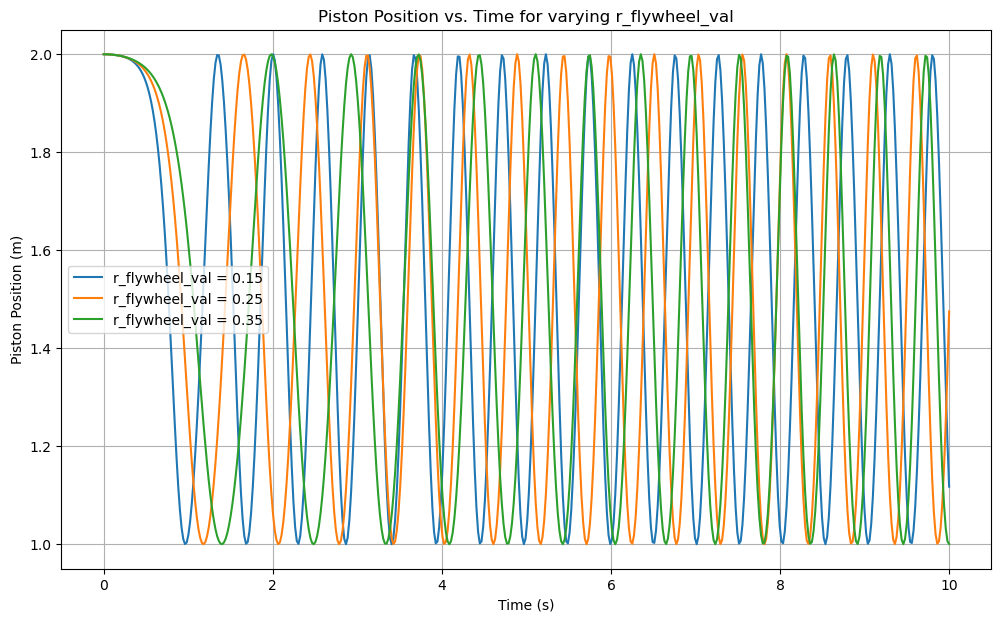

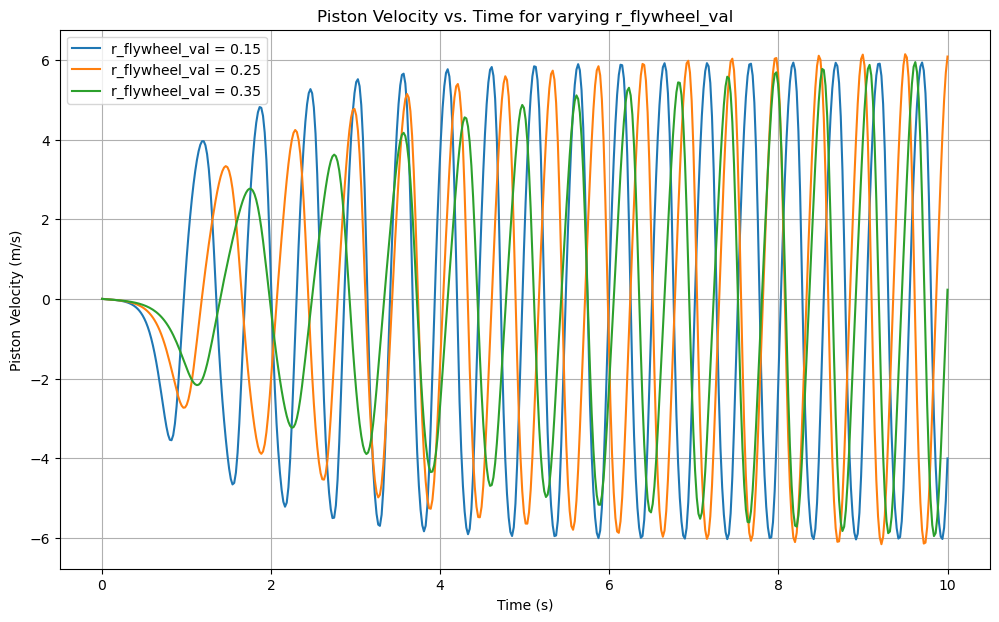

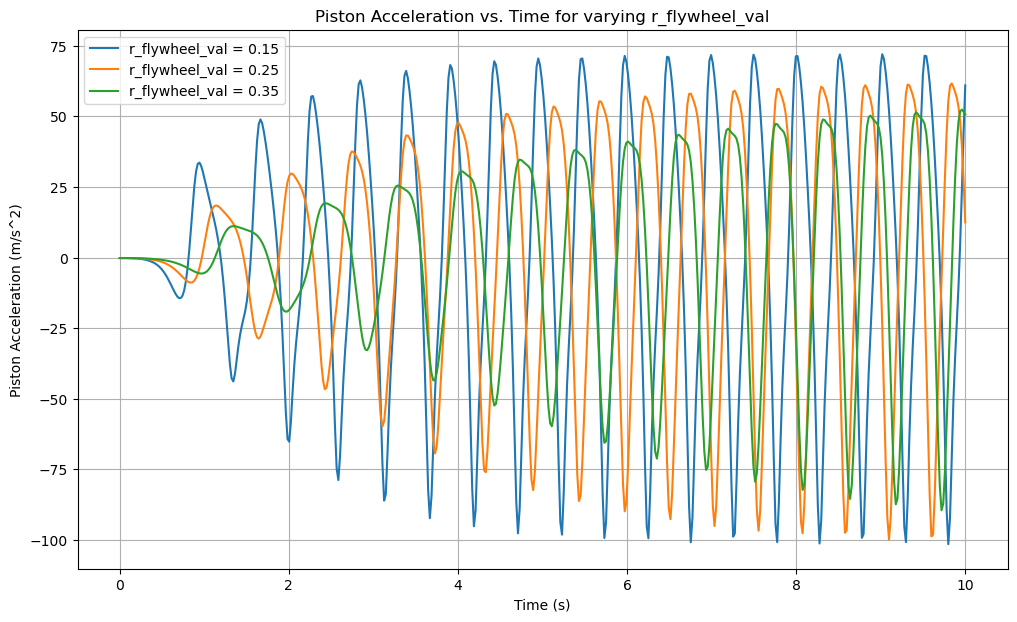

In [195]:
# Cell 16: Execute plotting

if all_simulation_results:
    # Example: Plotting for the 'parameter_to_vary' defined in Cell 14
    plot_kinematic_comparison(all_simulation_results, parameter_to_vary, "position", "m")
    plot_kinematic_comparison(all_simulation_results, parameter_to_vary, "velocity", "m/s")
    plot_kinematic_comparison(all_simulation_results, parameter_to_vary, "acceleration", "m/s^2")
else:
    print("No simulation results to plot. Please run Cell 14 first.")